In [1]:
import numpy as np
import matplotlib.pyplot as plt

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [175]:
import torch


def normal_cdf(x, mu=0, sigma=1):
    return 0.5*(1 + torch.erf((x - mu)/(sigma*torch.sqrt(torch.tensor(2.)))))


def V_BS_put(S, tau, K, r, sigma):
    d1 = (torch.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*torch.sqrt(tau))
    d2 = d1 - sigma*torch.sqrt(tau)
    return K*torch.exp(-r*tau)*normal_cdf(-d2) - S*normal_cdf(-d1)


# def get_derivative(y, x, n=1):
#     if n == 0:
#         return y
#     else:
#         dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
#                                    create_graph=True, retain_graph=True, allow_unused=True)[0]
#         return get_derivative(dydx, x, n-1)


class EuropeanPINN(torch.nn.Module):
    def __init__(self, nn, K, T, r, sigma, S_inf=1e8):
        super(EuropeanPINN, self).__init__()
        self.V_nn = nn
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.S_inf = S_inf

    def forward(self, S, tau):
        V = self.V_nn(torch.cat((S, tau), dim=1))
        return V
    
    def pde_nn(self, S, tau):
        V = self.forward(S, tau)
        V_tau = torch.autograd.grad(V, tau, grad_outputs=torch.ones_like(V),
                                    create_graph=True, retain_graph=True, allow_unused=True)[0]
        V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V),
                                  create_graph=True, retain_graph=True, allow_unused=True)[0]
        V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S),
                                   create_graph=True, retain_graph=True, allow_unused=True)[0]

        return V_tau - 0.5*self.sigma**2*S**2*V_SS - self.r*S*V_S + self.r*V

    def loss_ib(self, S, tau, V):
        return torch.mean((self.forward(S, tau) - V)**2)

    def loss_pde(self, S, tau):
        return torch.mean(self.pde_nn(S, tau)**2)

    def loss_data(self, S, tau, V):
        if S is None:
            return 0
        return torch.mean((self.forward(S, tau) - V)**2)

    def loss(self, S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data=None, tau_data=None, V_data=None):
        return self.loss_ib(S_ib, tau_ib, V_ib) + \
               self.loss_pde(S_pde, tau_pde) + \
               self.loss_data(S_data, tau_data, V_data)

    def predict(self, x):
        return self.forward(x)


In [199]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 20  # truncted domain (0, inf]

# nn architecture
nn = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 1)
)

N_i = 160
N_b = 40
N_pde = 2500
N_data = 0
# make data
# random sample S in (0, S_inf), tau in (0, 1)
# initial condition V(S, 0) = max(K - S, 0)
S_ib = torch.rand(N_i, 1)*S_inf
tau_ib = torch.zeros(N_i, 1)
V_ib = torch.max(K - S_ib, torch.zeros_like(S_ib))
# boundary condition V(0, tau) = K*exp(-r*tau), V(S_inf, tau) = 0
S_ib = torch.cat([S_ib, torch.zeros(N_b, 1), torch.full((N_b, 1), S_inf)], dim=0)
tau_ib = torch.cat([tau_ib, torch.rand(2*N_b, 1)], dim=0)
V_ib = torch.cat([V_ib, K*torch.exp(-r*tau_ib[N_i:N_i+N_b]), torch.zeros((N_b, 1))], dim=0)
# PDE points
S_pde = torch.rand(N_pde, 1)*S_inf
tau_pde = torch.rand(N_pde, 1)
#  data points
if N_data > 0:
    S_data = torch.rand(N_data, 1)*S_inf
    tau_data = torch.rand(N_data, 1)
    V_data = V_BS_put(S_data, tau_data, K, r, sigma)
    S_data.requires_grad = True
    tau_data.requires_grad = True
    V_data.requires_grad = True
else:
    S_data = None
    tau_data = None
    V_data = None


# require_grad = True
S_ib.requires_grad = True
tau_ib.requires_grad = True
V_ib.requires_grad = True
S_pde.requires_grad = True
tau_pde.requires_grad = True

100%|██████████| 2000/2000 [00:11<00:00, 166.76it/s]


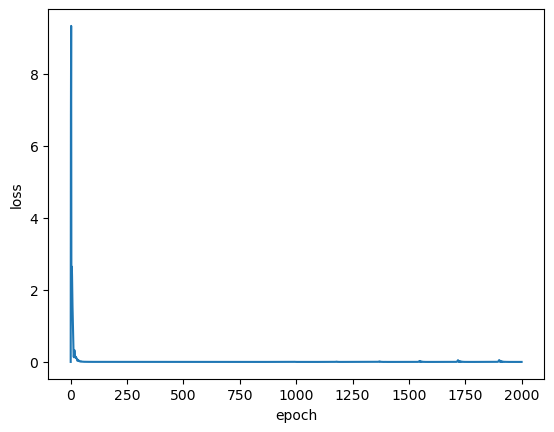

In [231]:
from tqdm import tqdm  # progress bar


# training
model = EuropeanPINN(nn, K, T, r, sigma, S_inf)
# first 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
n_epochs = 2000
losses = []
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    loss = model.loss(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

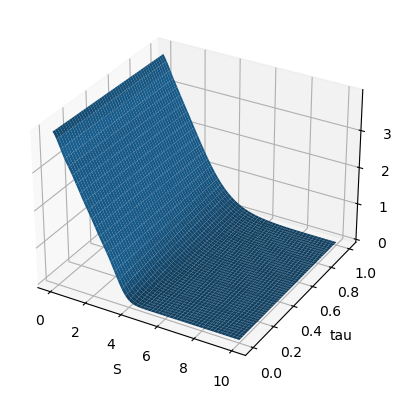

In [232]:
# plot
S_plot = torch.linspace(0, 10, 1000)
tau_plot = torch.linspace(0, T, 1000)
S_plot, tau_plot = torch.meshgrid(S_plot, tau_plot)
V_plot = model.forward(S_plot.reshape(-1, 1), tau_plot.reshape(-1, 1)).detach().reshape(1000, 1000)
# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_plot.numpy(), tau_plot.numpy(), V_plot.numpy())
ax.set_xlabel('S')
ax.set_ylabel('tau')
ax.set_zlabel('V')
plt.show()

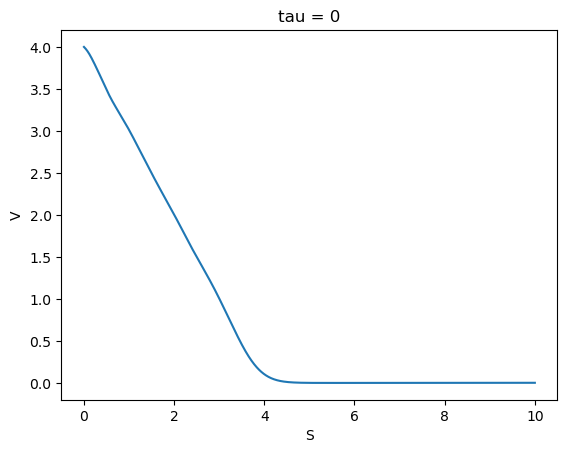

In [233]:
# plot tau = 0
S_plot = torch.linspace(0, 10, 1000)
V_plot = model.forward(S_plot.reshape(-1, 1), torch.zeros(1000, 1)).detach()
plt.plot(S_plot, V_plot)
plt.xlabel('S')
plt.ylabel('V')
plt.title('tau = 0')
plt.show()

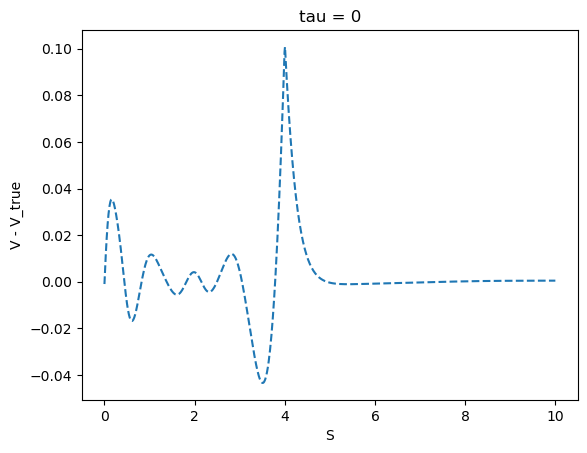

In [234]:
# plot pointwise error at tau = 0
S_plot = torch.linspace(0, 10, 1000)
V_plot = model.forward(S_plot.reshape(-1, 1), torch.zeros(1000, 1)).detach().reshape(-1)
V_true = torch.max(K - S_plot, torch.zeros_like(S_plot))
plt.plot(S_plot, V_plot - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('V - V_true')
plt.title('tau = 0')
plt.show()